# Ilostat Analyse Notebook

Author: Jade Bullock

Date: 06/04/2024

This Jupyter Notebook performs exploratory data analysis and modeling on the merged Ilostat datasets, with the aim of identifying which labor-related factors best predict national happiness (as measured by the World Happiness Report's "Happiness Index").

## Main Steps:
-----------
1. Load the cleaned and merged Ilosat dataset.
2. Visualize correlations via heatmaps and bar charts.
3. Explore individual variable relationships using scatter plots.
4. Split the data to group the data into two models:
    - Model A
    - Model B
5. Model the two data sets using:
    - Linear Regression
    - Random Forest Regressor
6. Evaluate model accuracy using R² and RMSE.
7. Interpret feature importance and highlight vulnerability patterns such as underreported safety data and regional inequalities.

## Outputs:
--------
- Correlation heatmap and bar plots
- Scatter plots (Happiness Index vs selected indicators)
- Feature importance rankings (linear & tree-based)
- Model accuracy summary
- Region-level labor and poverty summaries

In [144]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


In [119]:
# Load merged and cleaned dataset
df = pd.read_csv("../data/clean/ilostat_merge.csv")

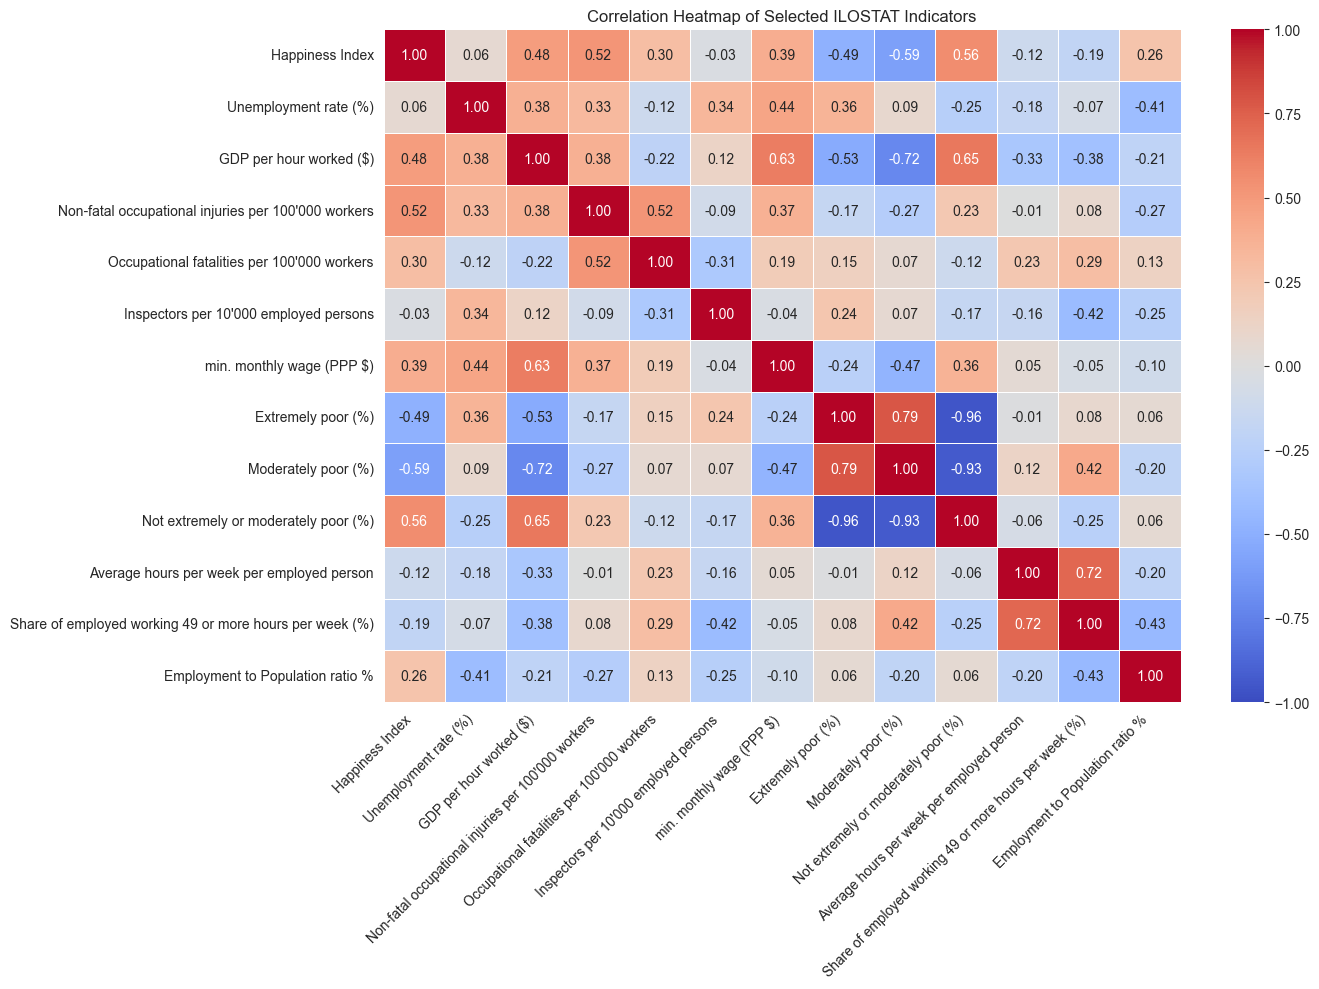

In [120]:
# === List of selected columns ===

# Select only numeric columns for correlation analysis
numeric_data = df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# === Filter only available columns ===
available_columns = [col for col in numeric_data if col in df.columns]
filtered_df = df[available_columns].dropna()

# === Generate heatmap ===
plt.figure(figsize=(14, 10))
correlation_matrix = filtered_df.corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Selected ILOSTAT Indicators")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Poor rating  - strong correlation to happiness index.
GDP per hour worked - strong correlation to happiness index.
Non fatal occupational injuries linked to happiness index


Based on clean and merge some columns do not have data in every row.  For the correlation matrix above, the rows missing not all Compare correlation of individial items to happiness index (so that all rows are utilised)

In [121]:
# Columns you'd like to test against Happiness Index
target = "Happiness Index"
columns_to_compare = [
    "Unemployment rate (%)",
    "GDP per hour worked ($)",
    "Non-fatal occupational injuries per 100'000 workers",
    "Occupational fatalities per 100'000 workers",
    "Inspectors per 10'000 employed persons",
    "min. monthly wage (PPP $)",
    "Extremely poor (%)",
    "Moderately poor (%)",
    "Not extremely or moderately poor (%)",
    "Average hours per week per employed person",
    "Share of employed working 49 or more hours per week (%)",
    "Employment to Population ratio %"
]

# Compute pairwise correlation (Happiness vs each column)
results = []
for col in columns_to_compare:
    if col in df.columns:
        subset = df[[target, col]].dropna()
        if len(subset) > 1:
            corr = subset[target].corr(subset[col])
            results.append((col, round(corr, 3), len(subset)))

# Format and display results
correlation_df = pd.DataFrame(results, columns=["Indicator", "Correlation with Happiness", "Compared Rows"])
correlation_df.sort_values("Correlation with Happiness", ascending=False, inplace=True)
print(correlation_df)

                                            Indicator  \
1                             GDP per hour worked ($)   
5                           min. monthly wage (PPP $)   
8                Not extremely or moderately poor (%)   
2   Non-fatal occupational injuries per 100'000 wo...   
11                   Employment to Population ratio %   
4              Inspectors per 10'000 employed persons   
0                               Unemployment rate (%)   
3         Occupational fatalities per 100'000 workers   
9          Average hours per week per employed person   
10  Share of employed working 49 or more hours per...   
6                                  Extremely poor (%)   
7                                 Moderately poor (%)   

    Correlation with Happiness  Compared Rows  
1                        0.669            147  
5                        0.669            133  
8                        0.664            109  
2                        0.320             71  
11                

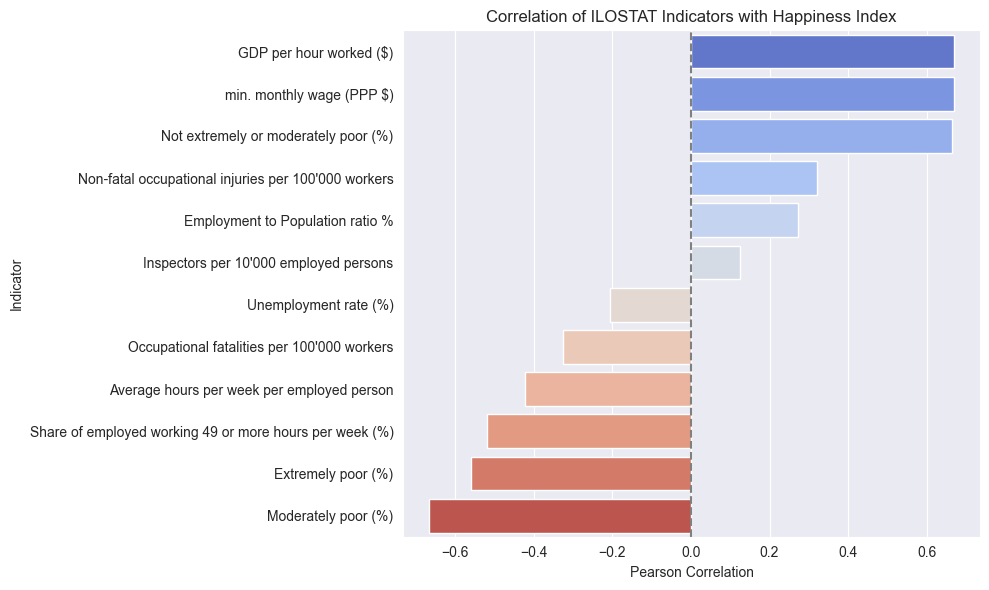

In [122]:
# Plot correlation bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=correlation_df, x="Correlation with Happiness", y="Indicator", hue="Indicator",palette="coolwarm")
plt.axvline(0, color='gray', linestyle='--')
plt.title("Correlation of ILOSTAT Indicators with Happiness Index")
plt.xlabel("Pearson Correlation")
plt.ylabel("Indicator")
plt.tight_layout()
#plt.savefig("visuals/happiness_correlation_plot.png", dpi=300)
plt.show()

Create scatter plots


 Scatter plots saved to: visuals/happiness_scatter_plots_ilostat.png


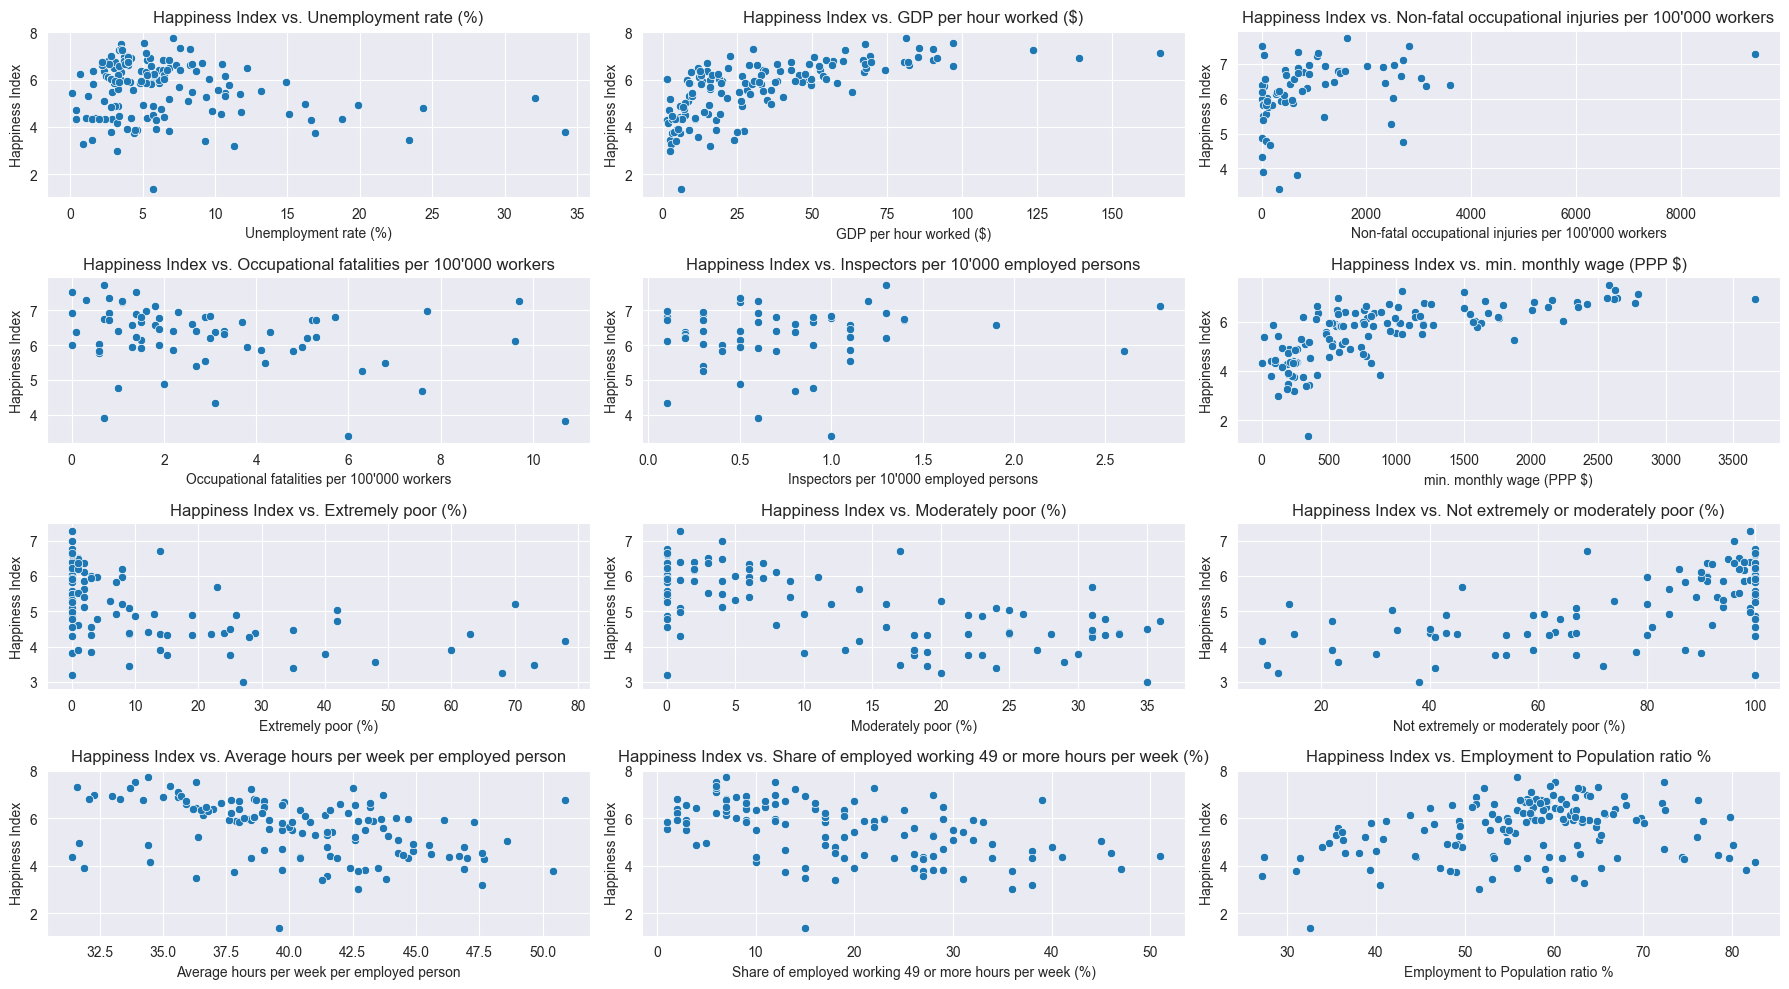

In [123]:
# Use key variables from above to plot against the Happiness Index (columns_to_compare)


# Create a 2x3 grid of scatter plots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(columns_to_compare):
    sns.scatterplot(
        data=df,
        x=var,
        y="Happiness Index",
        ax=axes[i],
        edgecolor="w"
    )
    axes[i].set_title(f"Happiness Index vs. {var}", fontsize=12)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Happiness Index")

# Layout adjustment
plt.tight_layout()

# Save to file
plt.savefig("visuals/happiness_scatter_plots_ilostat.png", dpi=300, bbox_inches="tight")
print(" Scatter plots saved to: visuals/happiness_scatter_plots_ilostat.png")

# Show the plots
plt.show()

Compare how many entries we have and the Pearsons Correlation - to understand where data is missing

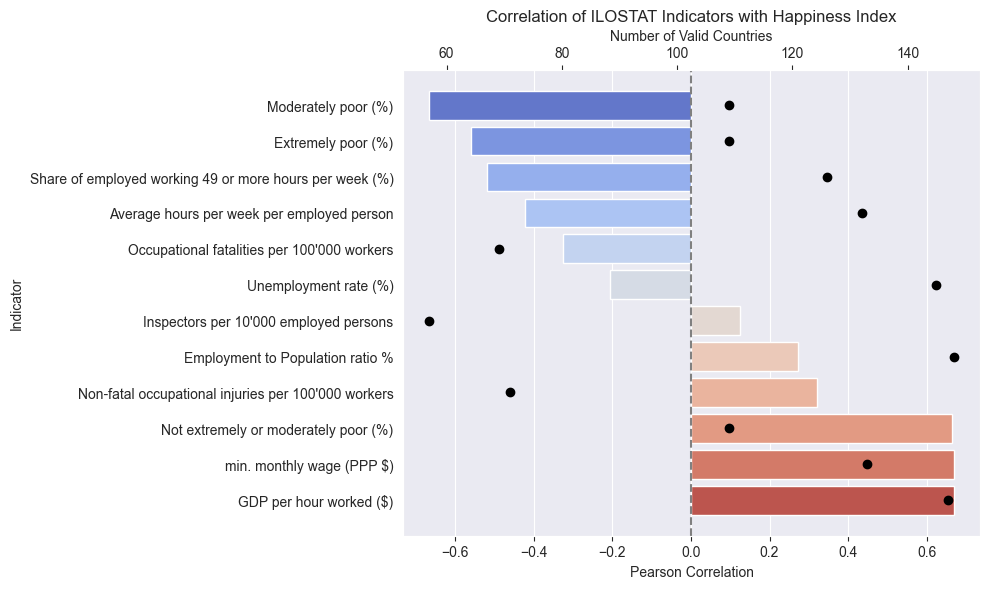

In [124]:
# Compute pairwise correlations and row counts
correlation_data = []
for col in columns_to_compare:
    if col in df.columns:
        subset = df[[target, col]].dropna()
        if len(subset) > 1:
            corr = subset[target].corr(subset[col])
            correlation_data.append({
                "Indicator": col,
                "Correlation with Happiness": round(corr, 3),
                "Rows Compared": len(subset)
            })

# Build the correlation DataFrame
corr_df = pd.DataFrame(correlation_data)
corr_df.sort_values("Correlation with Happiness", inplace=True)

# Create main figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Correlation barplot
sns.barplot(
    data=corr_df,
    x="Correlation with Happiness",
    y="Indicator",
    hue="Indicator",
    palette="coolwarm",
    ax=ax1,
    legend=False
)
ax1.axvline(0, color='gray', linestyle='--')
ax1.set_title("Correlation of ILOSTAT Indicators with Happiness Index")
ax1.set_xlabel("Pearson Correlation")
ax1.set_ylabel("Indicator")

# Add secondary axis for row counts
ax2 = ax1.twiny()
ax2.scatter(corr_df["Rows Compared"], corr_df["Indicator"], color="black", marker="o", label="Row Count")
ax2.set_xlabel("Number of Valid Countries")
ax2.grid(False)

plt.tight_layout()
plt.show()


Only have approx 70 entries for Occupational fatalities.


Perform modeling using two different models (split analysis into two models):
-  Model A: All indicators except sparse ones
    - Use all rows (maximal data)
    - Include only features with good coverage (120+ countries)


- Model B: Sparse features only
    - Include sparse but interesting features ( "Occupational fatalities...")
    - Use only rows where those features exist (e.g., 70 rows)


Define the two models for analysis



In [125]:
# Define target
target = "Happiness Index"

# Filter valid features: only those with sufficient non-null data
min_valid_rows = 120
model_a_features = [
    col for col in columns_to_compare
    if col in df.columns and df[[target, col]].dropna().shape[0] > min_valid_rows
]

# Model A: Features with enough valid data (at least 120 valid comparisons)
df_a = df[model_a_features + [target]].dropna()

# Model B: All available features (drops more rows due to sparsity)
model_b_features = [col for col in columns_to_compare if col in df.columns]
df_b = df[model_b_features + [target]].dropna()



In [126]:
# Function to train and evaluate models
def run_models(df_subset, feature_list):
    '''Runs both model a and model b for both linear regression and random forest'''
    X = df_subset[feature_list]
    y = df_subset[target]

    # Standardize for linear regression
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_scaled, y)
    linear_result = pd.DataFrame({
        "Feature": feature_list,
        "Linear Coefficient": lr.coef_
    })

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    forest_result = pd.DataFrame({
        "Feature": feature_list,
        "Random Forest Importance": rf.feature_importances_
    })

    # Combine and return
    combined = linear_result.merge(forest_result, on="Feature")
    return combined.sort_values("Random Forest Importance", ascending=False)

In [127]:

# Run model A and  print coefficients and importance
results_a = run_models(df_a, model_a_features)
# plot results
print("Model A (Full Dataset, No Sparse Columns):\n", results_a.to_string(index=False) )


Model A (Full Dataset, No Sparse Columns):
                                                 Feature  Linear Coefficient  Random Forest Importance
                              min. monthly wage (PPP $)            0.476660                  0.602884
                       Employment to Population ratio %            0.164699                  0.161931
                                GDP per hour worked ($)            0.246009                  0.095941
                                  Unemployment rate (%)           -0.101131                  0.051738
Share of employed working 49 or more hours per week (%)           -0.350772                  0.044996
             Average hours per week per employed person            0.157624                  0.042510


In [128]:
# Run model B and print coefficients and importance
results_b = run_models(df_b, model_b_features)
# plot results
print("\nModel B (Smaller Dataset, Includes Sparse Features):\n", results_b.to_string(index=False))


Model B (Smaller Dataset, Includes Sparse Features):
                                                 Feature  Linear Coefficient  Random Forest Importance
                              min. monthly wage (PPP $)           -0.184433                  0.354923
    Non-fatal occupational injuries per 100'000 workers            0.348972                  0.163446
                                GDP per hour worked ($)            0.624556                  0.119766
                                    Moderately poor (%)           -6.518490                  0.082428
             Average hours per week per employed person           -0.152091                  0.059714
                   Not extremely or moderately poor (%)          -14.910391                  0.055352
                       Employment to Population ratio %            1.028557                  0.046830
Share of employed working 49 or more hours per week (%)            0.577987                  0.035868
            Occupational fa

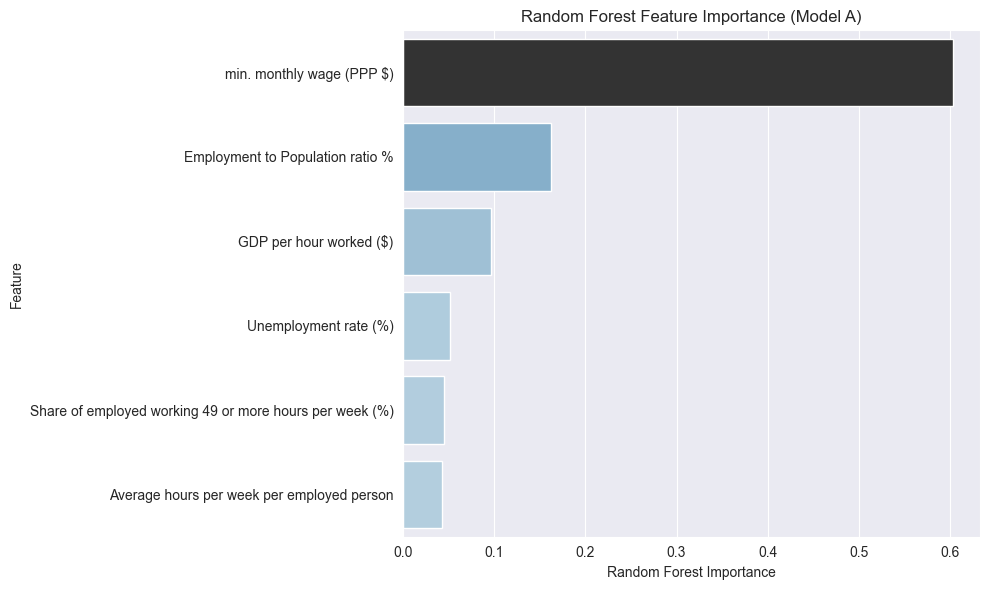

In [129]:
# Plot Random Forest Importance from Model A
plt.figure(figsize=(10, 6))
sns.barplot(
    data = results_a.sort_values("Random Forest Importance", ascending= False),
    y="Feature", x="Random Forest Importance", hue= "Random Forest Importance", palette="Blues_d"
)
plt.title("Random Forest Feature Importance (Model A)")
plt.tight_layout()
plt.legend().remove()
plt.show()


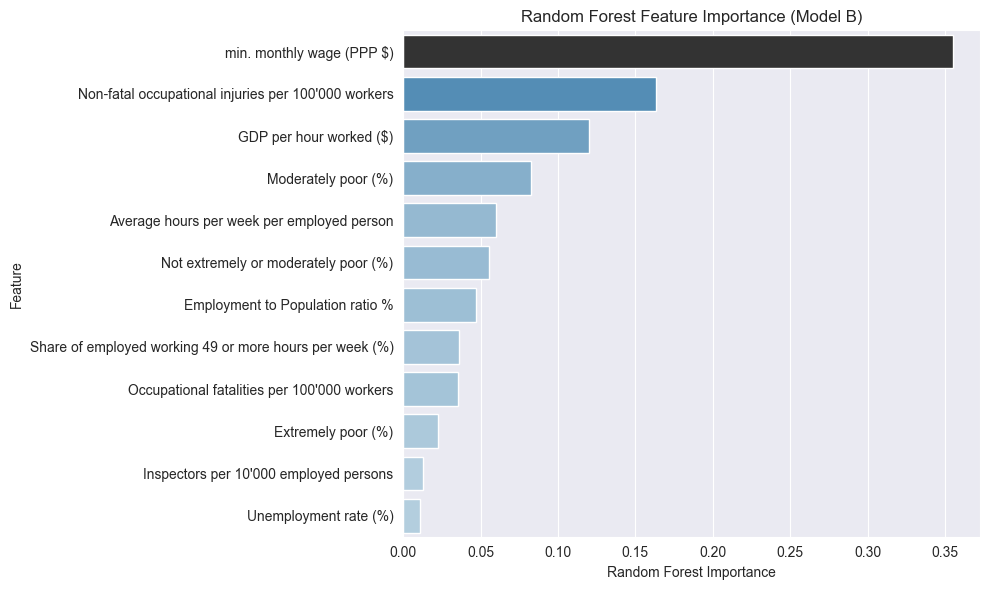

In [130]:
# Plot Random Forest Importance from Model B
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_b.sort_values("Random Forest Importance", ascending=False),
    y="Feature", x="Random Forest Importance", hue= "Random Forest Importance", palette="Blues_d"
)
plt.title("Random Forest Feature Importance (Model B)")
plt.tight_layout()
plt.legend().remove()
plt.show()

### 5. Analyze and interpret feature importance from both models.
Evaluate Linear vs.Random Forest for Model A and Model B

In [138]:
def evaluate_model(df_subset, feature_list, label):
    """Evaluates model accuracy with R² and RMSE and adds Pearson correlation"""

    # Prepare features and target
    X = df_subset[feature_list]
    y = df_subset["Happiness Index"]

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train models for evaluation
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    lr.fit(X_scaled, y)
    rf.fit(X, y)

    # Pearson correlations
    corrs = {f: df_subset[f].corr(y) for f in feature_list}
    correlation_df = pd.DataFrame.from_dict(corrs, orient="index", columns=["Pearson Correlation"])
    correlation_df.reset_index(inplace=True)
    correlation_df.rename(columns={"index": "Feature"}, inplace=True)

    # Cross-validated R²
    lin_r2 = cross_val_score(lr, X_scaled, y, cv=5, scoring='r2')
    rf_r2 = cross_val_score(rf, X, y, cv=5, scoring='r2')

    # RMSE
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    lin_rmse = np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))

    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_rmse = np.sqrt(mean_squared_error(y_test_rf, rf.predict(X_test_rf)))

    # Print summary
    print(f"\n {label} — Model Evaluation Summary")
    print("-" * 50)
    print(f"Linear Regression R² (CV mean): {lin_r2.mean():.3f}")
    print(f"Random Forest R² (CV mean):    {rf_r2.mean():.3f}")
    print(f"Linear Regression RMSE:        {lin_rmse:.3f}")
    print(f"Random Forest RMSE:            {rf_rmse:.3f}")

    return correlation_df


In [145]:
# Run feature comparison
results_a = run_models(df_a, model_a_features)
results_b = run_models(df_b, model_b_features)

# Evaluate and enrich with correlation
correlation_a = evaluate_model(df_a, model_a_features, "Model A (Robust Data)")
correlation_b = evaluate_model(df_b, model_b_features, "Model B (Includes Sparse Features)")

# Merge if needed
results_a = results_a.merge(correlation_a, on="Feature")
results_b = results_b.merge(correlation_b, on="Feature")


📊 Model A (Robust Data) — Model Evaluation Summary
--------------------------------------------------
Linear Regression R² (CV mean): 0.473
Random Forest R² (CV mean):    0.541
Linear Regression RMSE:        1.017
Random Forest RMSE:            0.307

📊 Model B (Includes Sparse Features) — Model Evaluation Summary
--------------------------------------------------
Linear Regression R² (CV mean): -1.635
Random Forest R² (CV mean):    -0.110
Linear Regression RMSE:        0.109
Random Forest RMSE:            0.366


Explore relationship between occupational fatalities to min. monthly wages to determine whether poorer countries are not reporting fatality data.

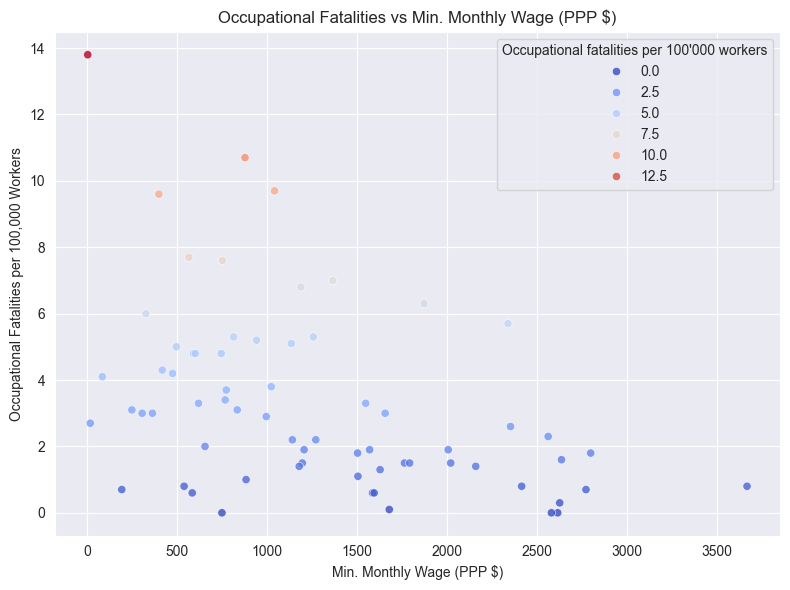

Correlation: -0.44


In [37]:
# Filter for relevant columns and drop rows with missing data
subset = df[[
    "Country",
    "Occupational fatalities per 100'000 workers",
    "min. monthly wage (PPP $)"
]].dropna()

# Plot: Fatalities vs Minimum Wage
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=subset,
    x="min. monthly wage (PPP $)",
    y="Occupational fatalities per 100'000 workers",
    hue="Occupational fatalities per 100'000 workers",
    palette="coolwarm",
    edgecolor="w",
    alpha=0.8
)
plt.title("Occupational Fatalities vs Min. Monthly Wage (PPP $)")
plt.xlabel("Min. Monthly Wage (PPP $)")
plt.ylabel("Occupational Fatalities per 100,000 Workers")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = subset["min. monthly wage (PPP $)"].corr(
    subset["Occupational fatalities per 100'000 workers"]
)

print(f"Correlation: {correlation:.2f}")

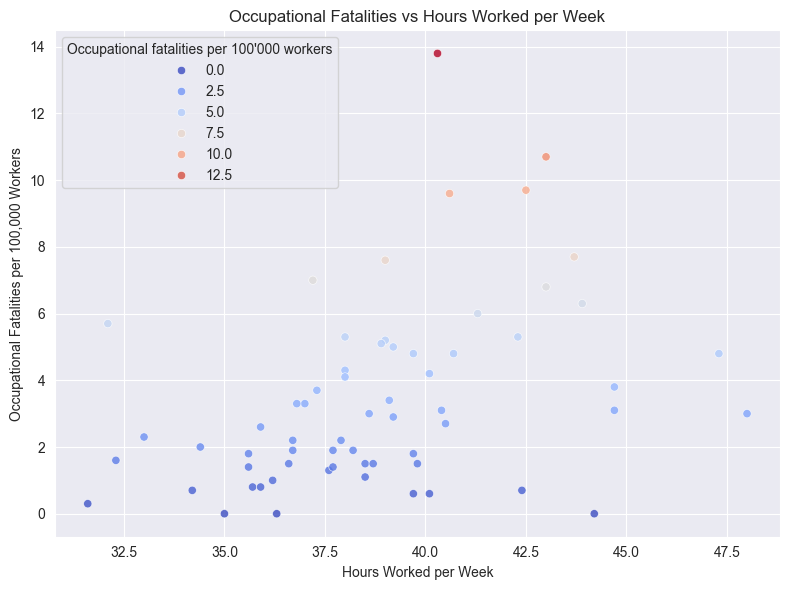

Correlation: 0.39


In [38]:
# Ensure all needed columns are present
subset = df[[
    "Country",
    "Average hours per week per employed person",
    "Occupational fatalities per 100'000 workers",
    "min. monthly wage (PPP $)"
]].dropna()
# Plot: Fatalities vs Working Hours
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=subset,
    x="Average hours per week per employed person",
    y="Occupational fatalities per 100'000 workers",
    hue="Occupational fatalities per 100'000 workers",
    palette="coolwarm",
    edgecolor="w",
    alpha=0.8
)
plt.title("Occupational Fatalities vs Hours Worked per Week")
plt.xlabel("Hours Worked per Week")
plt.ylabel("Occupational Fatalities per 100,000 Workers")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = subset["Average hours per week per employed person"].corr(
    subset["Occupational fatalities per 100'000 workers"]
)


print(f"Correlation: {correlation:.2f}")


Explore in more detail if there is a relationship between a lack of reporting fatalities, GDP and happiness:
- Flags countries with no safety reporting
- Filters for low productivity + long work hours
        - Have low GDP/hour (< $20)
        - Work long hours (> 40 hours/week)
- Sorts them by Happiness Index for a vulnerability snapshot


In [39]:
# Flag countries missing all safety-related data
safety_columns = [
    "Occupational fatalities per 100'000 workers",
    "Non-fatal occupational injuries per 100'000 workers",
    "Inspectors per 10'000 employed persons"
]

main_metrics = [
    "Happiness Index",
    "GDP per hour worked ($)",
    "Employment to Population ratio %",
    "min. monthly wage (PPP $)"
]

# Flag if all safety columns are missing but at least one main metric is available
df["Missing Safety Data"] = df[safety_columns].isnull().all(axis=1) & df[main_metrics].notnull().any(axis=1)

# Flag "at-risk" countries with low GDP/hour & high working hours
low_gdp_threshold = 20     # below $20 GDP/hour
high_hours_threshold = 40  # more than 40 hours/week

# Filter based on the criteria
at_risk_countries = df[
    (df["Missing Safety Data"] == True) &
    (df["GDP per hour worked ($)"] < low_gdp_threshold) &
    (df["Average hours per week per employed person"] > high_hours_threshold)
]

#  Select relevant columns for comparison
comparison_cols = [
    "Country",
    "Happiness Index",
    "GDP per hour worked ($)",
    "Average hours per week per employed person",
    "Extremely poor (%)"

]

# Sort by happiness to identify the most vulnerable
at_risk_summary = at_risk_countries[comparison_cols].sort_values("Happiness Index", ascending=True)


#  Print summary
print(" At-risk countries with low GDP/hour, high hours, missing safety data:\n")
print(at_risk_summary)


 At-risk countries with low GDP/hour, high hours, missing safety data:

                   Country  Happiness Index  GDP per hour worked ($)  \
182           Sierra Leone            2.998                      2.6   
110                Lebanon            3.188                     15.9   
225                  Yemen            3.561                     12.0   
111                Lesotho            3.757                      3.2   
14              Bangladesh            3.851                      8.7   
226                 Zambia            3.912                      5.2   
112                Liberia            4.277                      1.5   
101                 Jordan            4.310                     17.9   
31                Cambodia            4.341                      4.0   
122                   Mali            4.345                      3.0   
19                   Benin            4.357                      4.2   
28            Burkina Faso            4.383                     

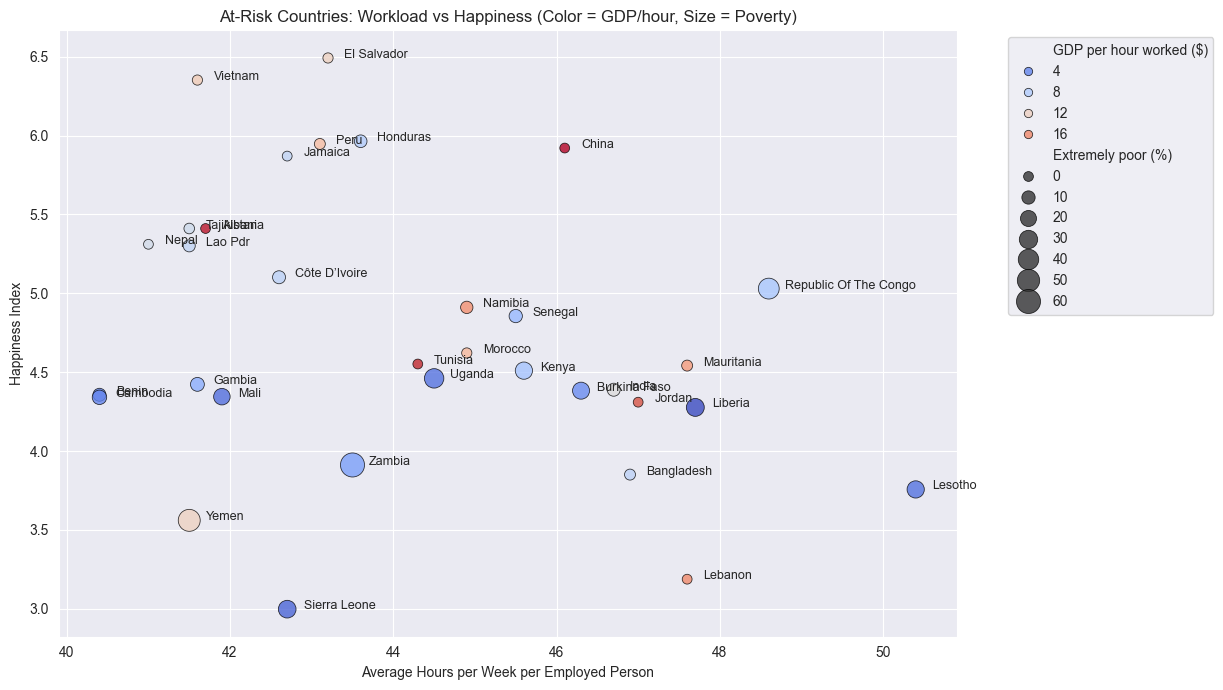

In [40]:
# Create the scatter plot ===
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=at_risk_countries,
    x="Average hours per week per employed person",
    y="Happiness Index",
    size="Extremely poor (%)",
    sizes=(50, 300),
    hue="GDP per hour worked ($)",
    palette="coolwarm",
    edgecolor="black",
    alpha=0.8,
    legend="brief"
)

# Annotate each country
for _, row in at_risk_countries.iterrows():
    plt.text(
        row["Average hours per week per employed person"] + 0.2,
        row["Happiness Index"],
        row["Country"],
        fontsize=9
    )

plt.title("At-Risk Countries: Workload vs Happiness (Color = GDP/hour, Size = Poverty)")
plt.xlabel("Average Hours per Week per Employed Person")
plt.ylabel("Happiness Index")
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

NEED TO EXPLAIN WHAT THIS MEANS


 Regional Inequality Summary:

               Extreme Poverty (%)  Moderate Poverty (%)  Avg. Hours/Week  \
Region                                                                      
Africa                       17.33                 22.00            42.23   
Asia                          3.50                 14.50            44.92   
Latin America                 0.33                  2.67            39.90   

               Min Wage (PPP $)  Avg. Happiness Index  
Region                                                 
Africa                   361.33                  4.69  
Asia                     534.00                  4.94  
Latin America            582.33                  6.62  


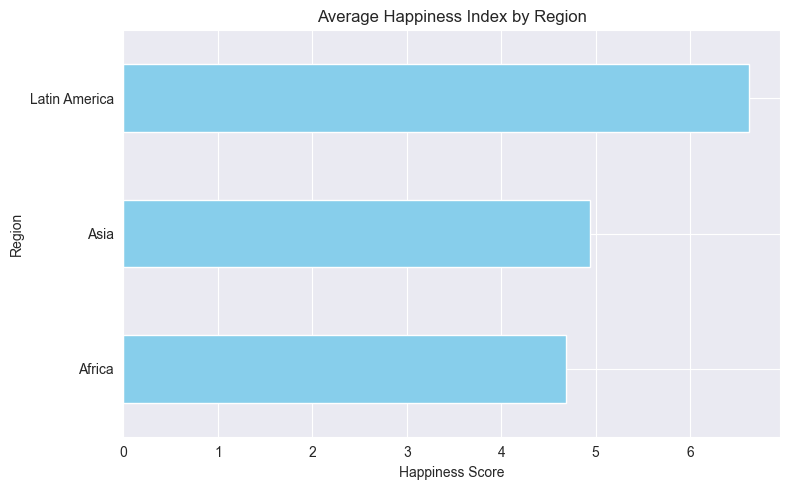

In [45]:

# Manually defined region mapping
region_map = {
    "Germany": "Europe",
    "France": "Europe",
    "Norway": "Europe",
    "Spain": "Europe",
    "Italy": "Europe",
    "United States": "North America",
    "Canada": "North America",
    "Mexico": "Latin America",
    "Brazil": "Latin America",
    "Argentina": "Latin America",
    "India": "Asia",
    "China": "Asia",
    "Indonesia": "Asia",
    "Bangladesh": "Asia",
    "Japan": "Asia",
    "South Africa": "Africa",
    "Kenya": "Africa",
    "Nigeria": "Africa",
    "Ghana": "Africa",
    "Australia": "Oceania",
    "New Zealand": "Oceania"
}
# Map region to dataframe
df["Region"] = df["Country"].map(region_map)

# Drop rows where all required columns are missing before grouping
filtered_df = df.dropna(subset=[
    "Extremely poor (%)",
    "Moderately poor (%)",
    "Average hours per week per employed person",
    "min. monthly wage (PPP $)",
    "Happiness Index"
])

grouped = filtered_df.groupby("Region")[[
    "Extremely poor (%)",
    "Moderately poor (%)",
    "Average hours per week per employed person",
    "min. monthly wage (PPP $)",
    "Happiness Index"
]].mean().round(2)

# === Step 3: Rename for clarity ===
grouped.rename(columns={
    "Extremely poor (%)": "Extreme Poverty (%)",
    "Moderately poor (%)": "Moderate Poverty (%)",
    "Average hours per week per employed person": "Avg. Hours/Week",
    "min. monthly wage (PPP $)": "Min Wage (PPP $)",
    "Happiness Index": "Avg. Happiness Index"
}, inplace=True)

# === Step 4: Print or Export ===
print("\n Regional Inequality Summary:\n")
print(grouped)

#  export to CSV
grouped.to_csv("visuals/regional_inequality_summary.csv")


# Bar plot: Happiness by Region
grouped["Avg. Happiness Index"].plot(kind="barh", color="skyblue", figsize=(8, 5))
plt.title("Average Happiness Index by Region")
plt.xlabel("Happiness Score")
plt.grid(True)
plt.tight_layout()
plt.show()

###  Key Findings

- **GDP per hour worked** and **minimum wage (PPP $)** were the strongest positive predictors of happiness.
- **Extreme poverty** was consistently a strong negative predictor.
- **Occupational fatalities** were missing in many low-wage countries — raising concerns about reporting transparency.
- Regional analysis shows **Latin America** reports higher happiness despite economic struggles — suggesting other cultural or policy factors at play.
